In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
array1 = np.load('/content/drive/MyDrive/dal_endsem/embeddings_1.npy')
array2 = np.load('/content/drive/MyDrive/dal_endsem/embeddings_2.npy')
X_train = np.concatenate((array1, array2))
X_test = np.load('/content/drive/MyDrive/dal_endsem/test_data.npy')

In [ ]:
def parse_label_file(filename, delimiter=';'):
    with open(filename, 'r') as f:
        lines = f.readlines()

    labels = []
    for line in lines:
        labels.append(line.strip().split(delimiter))

    return labels

def create_label_to_index(labels):
  unique_labels = set(labels)
  label_to_index = {label: i for i, label in enumerate(unique_labels)}
  return label_to_index

def to_multi_hot(labels, label_to_index):
  vocab_size = len(label_to_index)
  multi_hot = np.zeros(vocab_size)

  for label in labels:
    index = label_to_index[label]
    multi_hot[index] = 1

  return multi_hot

labelsfile1 = "/content/drive/MyDrive/dal_endsem/icd_codes_1.txt"
labels1 = parse_label_file(labelsfile1)
labelsfile2 = "/content/drive/MyDrive/dal_endsem/icd_codes_2.txt"
labels2 = parse_label_file(labelsfile2)
labels = labels1 + labels2

all_labels = []
for label in labels:
    all_labels += label
label_to_index = create_label_to_index(all_labels)

multi_hot = []
for label in labels:
    multi_hot.append(to_multi_hot(label, label_to_index))

y_train = np.array(multi_hot)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.4258 - loss: 0.0138 - val_accuracy: 0.4720 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 2/100
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.5922 - loss: 0.0019 - val_accuracy: 0.4681 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 3/100
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.5940 - loss: 0.0017 - val_accuracy: 0.5225 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 4/100
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6030 - loss: 0.0016 - val_accuracy: 0.4962 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 5/100
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6014 - loss: 0.0015 - val_accuracy: 0.5221 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 6/100
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6093 - loss: 0.0015 - val_accuracy: 0.4985 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 7/100
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy:

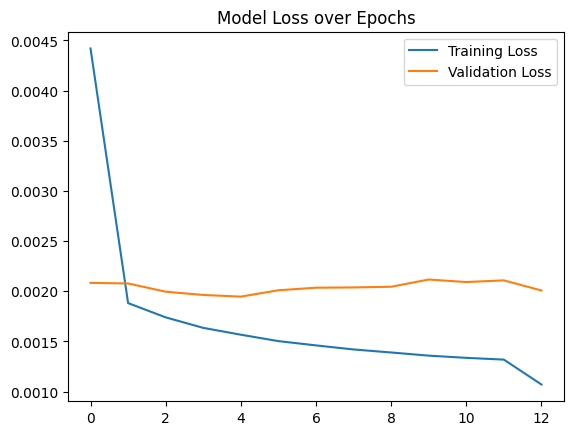

3110/3110 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


In [ ]:
model = Sequential([
    Dense(1024, activation='relu', input_dim=1024),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(1400, activation='sigmoid')
])

# Compile the model with Adam optimizer
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6)

# Reduce batch size for less memory usage
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2,
                    callbacks=[early_stopping, lr_scheduler])

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss over Epochs")
plt.legend()
plt.show()

In [ ]:
# Define a range of thresholds to evaluate
thresholds = [0.1, 0.15, 0.2, 0.25, 0.3]

# Placeholder to store the best threshold and corresponding score
best_threshold = 0.5
best_f2 = 0

# Predict probabilities on the test set
y_pred_prob = model.predict(X_test)

# Loop over each threshold
for threshold in thresholds:
    # Convert probabilities to binary predictions based on the current threshold
    y_pred = (y_pred_prob > threshold).astype(int)
    
    # Evaluate performance using average micro-F2 score
    f2 = fbeta_score(y_test, y_pred, beta=2, average='micro')
    
    print(f"Threshold: {threshold:.1f}, Micro-F2 Score: {f2:.4f}")
    
    # Update best threshold if this one is better
    if f2 > best_f2:
        best_f2 = f2
        best_threshold = threshold

print(f"\nBest Threshold: {best_threshold}, Best Micro-F2 Score: {best_f2:.4f}")

# Use the best threshold to make final predictions
final_y_pred = (y_pred_prob > best_threshold).astype(int)

In [ ]:
#Write Outputfile
################

def create_index_to_label(label_to_index):
  index_to_label = {v: k for k, v in label_to_index.items()}
  return index_to_label

index_to_label = create_index_to_label(label_to_index)

def create_txt_file(y_pred, index_to_label, filename="predicts.csv"):

  with open(filename, 'w') as f:
    f.write("id,labels\n")
    for i, prediction in enumerate(y_pred):
      labels = []
      for j, value in enumerate(prediction):
        if value == 1:
          labels.append(index_to_label[j])
      labels = sorted(labels)
      f.write(f"{i+1},{';'.join(labels)}\n")

# Predict the labels
y_pred_prob = model.predict(X_test)
threshold = 0.15
y_pred = (y_pred_prob > threshold).astype(int)

create_txt_file(y_pred, index_to_label)

3110/3110 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
